In [1]:
import os, sys
import gitpath
HOME_PATH = gitpath.root()
sys.path.append(HOME_PATH)

import pickle

import numpy as np

# Import pytorch dependencies
import torch
from torch.utils.data import DataLoader

# Import toolkits
from utils.visualization_3D_objects import *

from nn.pointnetae import *

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
DATASET = 'shapenet'
CATEGORY = 'chair'
DATA_PATH = os.path.join(HOME_PATH, "data/preprocessed", DATASET, CATEGORY)
CHECKPOINT_FOLDER = os.path.join(HOME_PATH, "saved_nn")
MODEL_TYPE = "PointNetAE" + '_' + CATEGORY

### Import Preprocessed ModelNet40 cars (Run shapenet_preprocessing.ipynb first to get these data)

In [3]:
#load all preprocessed data
f1 = open(os.path.join(DATA_PATH,'train.txt'),'rb')
X_train = pickle.load(f1)
f2 = open(os.path.join(DATA_PATH,'test.txt'),'rb')
X_test = pickle.load(f2)

In [4]:
BATCH_SIZE = 16

# construct dataloader
full_loader = DataLoader(
    np.vstack([X_train, X_test]), 
    batch_size=BATCH_SIZE, 
    shuffle=False, 
    num_workers=4,
    drop_last=True
)

In [5]:
global_feat = np.loadtxt("global_feat.csv", delimiter=",", dtype=float)

### Load saved model

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
if device =='cuda':
    print("Run on GPU...")
else:
    print("Run on CPU...")
    
model_test = PointNet_AE(3, 2048)
state_dict = torch.load(os.path.join(CHECKPOINT_FOLDER, MODEL_TYPE + '.pth')) # change the path to your own checkpoint file
model_test.cuda()
model_test.load_state_dict(state_dict['state_dict'])
model_test.eval()

print(state_dict['epoch'])

Run on GPU...
137


[806 592 220 ...  35 448 492]


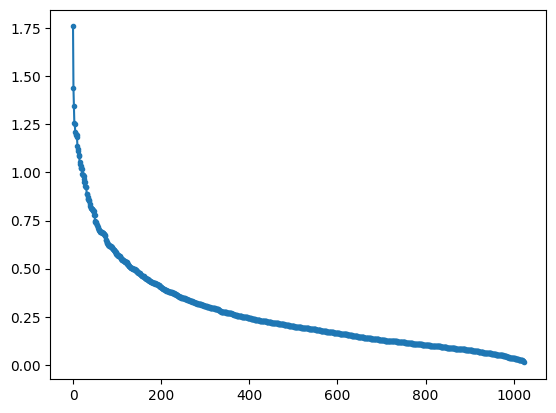

In [7]:
def computeAllDataTopK(global_feat, model_test, top_k = 25, mod_range = 5, n_step = 20):

    mu, var = np.mean(global_feat, axis = 0), np.var(global_feat, axis = 0)
    sigificant_feature_idx = np.argsort(var)[::-1]

    print(sigificant_feature_idx)
    plt.clf
    plt.plot(var[sigificant_feature_idx], '.-')
    plt.axis('tight')

    X_list = dict()
    for idx in sigificant_feature_idx[:top_k]:
        X_feat_list = []
        lower_bound = mu[idx] - var[idx] * mod_range
        higher_bound = mu[idx] + var[idx] * mod_range
        for step in np.linspace(lower_bound, higher_bound, n_step):
            new_features = torch.from_numpy(global_feat).float().cuda()
            new_features[:, idx] = step
            X = model_test.decoder(new_features).cpu().detach().numpy()
            X_feat_list.append(X)

        X_feat_list = np.asarray(X_feat_list)
        X_list[idx] = X_feat_list

    return X_list, sigificant_feature_idx

X_list, sigificant_feature_idx = computeAllDataTopK(global_feat, model_test)

In [8]:
# def examineObj(obj_idx):
#     for idx in X_list.keys():
#         draw3DpointsSlider(X_list[idx], idx, obj_idx)
#         end = int(input("Are you finished? 0: No, 1: Yes"))
#         if (end == 1):
#             break
        
#         clear_output(wait=True)

# examineObj(0)

In [12]:
idx = 1
fig = draw3DpointsSlider(X_list[sigificant_feature_idx[idx]], sigificant_feature_idx[idx], 0)